# Modelowanie statystyczne

> WSB-NLU, 2023-2024  
> Prowadządza: dr hab. Elżbieta Kubińska

> Autor: Andrzej Kocielski  
> [akocielski@student.wsb-nlu.edu.pl](akocielski@student.wsb-nlu.edu.pl)
___

## Zaimportowanie potrzebnych modułów

In [66]:
# do manipulacji ścieżkami do katalogów i plików
import os

# do obliczń numerycznych i analizy statystycznej
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import pingouin as pg

# do wizualizacji danych
import matplotlib.pyplot as plt
import seaborn as sns

## Załadowanie danych surowych
Dane tygodniowe dla wybranych spółek oraz indeksów w okresie od 01.01.2023 do 17.12.2023. Źródło danych: [stooq.pl](https://stooq.pl/).

In [67]:
# Ścieżka do danych
directory_path = 'dane-finansowe'

# Lista plików csv
csv_files = [file for file in os.listdir(directory_path) if file.endswith('.csv')]

print(f"Lista plików csv:")
for i, file in enumerate(csv_files):
    print(f"{i+1}. {file}") 

Lista plików csv:
1. comarch_w.csv
2. kghm_w.csv
3. eurpln_w.csv
4. spx_w.csv
5. echo_w.csv
6. xaupln_w.csv
7. apator_w.csv
8. wig_w.csv


### Przygotowanie danych roboczych

In [68]:
# Inicjalizaja pustego DataFrame
merged_df = pd.DataFrame()

# Zaczytanie danych z poszczególnych plików csv i dodanie do wspólnego DataFrame
for file in csv_files:
    file_path = os.path.join(directory_path, file)
    df_i = pd.read_csv(file_path)

    # Dodanie nazwy poliku do nazwy kolumny (poza pierwszą, czyli datą)
    nazwa_pliku = os.path.splitext(os.path.basename(file))[0][:-2].upper()
    df_i.columns = [df_i.columns[0]] + [f"{col}_{nazwa_pliku}" for col in df_i.columns[1:]]
    
    # Łączenie danych z poszczególnych plików 
    merged_df = pd.concat([merged_df, df_i], ignore_index=False, axis=1)

# Usunięcie powtórzonych kolumn z datami
merged_df = merged_df.T.drop_duplicates().T


In [69]:
# Zmiana typu danych 
cols = list(merged_df.columns)
cols.remove('Data')
for col in cols:
    merged_df[col] = merged_df[col].astype(float)

merged_df['Data'] = pd.to_datetime(merged_df['Data'])

# ustawienie daty jako indeksu
merged_df.set_index('Data', inplace=True)

In [70]:
print(f"Liczba obserwacji (wierszy): {merged_df.shape[0]}, liczba kolumn: {merged_df.shape[1]}")

Liczba obserwacji (wierszy): 1094, liczba kolumn: 38


In [71]:
print(f"Podgląd kilku pierwszych wierszy:")
merged_df.head()

Podgląd kilku pierwszych wierszy:


,Otwarcie_COMARCH,Najwyzszy_COMARCH,Najnizszy_COMARCH,Zamkniecie_COMARCH,Wolumen_COMARCH,Otwarcie_KGHM,Najwyzszy_KGHM,Najnizszy_KGHM,Zamkniecie_KGHM,Wolumen_KGHM,...,Otwarcie_APATOR,Najwyzszy_APATOR,Najnizszy_APATOR,Zamkniecie_APATOR,Wolumen_APATOR,Otwarcie_WIG,Najwyzszy_WIG,Najnizszy_WIG,Zamkniecie_WIG,Wolumen_WIG
Data,,,,,,,,,,,,,,,,,,,,,
2003-01-05,28.299032,28.601199,25.000256,27.099806,431401.754479,13.652976,14.044820,13.301183,13.896453,1.489253e+06,...,18.010886,18.134605,17.537700,18.134605,6271.654193,14397.8,14795.0,14210.2,14770.5,22771651.0
2003-01-12,27.500597,28.800545,27.402089,27.801831,177222.356697,14.003914,14.301871,13.652976,14.098994,2.988803e+06,...,18.010886,18.967117,17.895054,18.851244,16115.658748,14843.8,14917.6,14569.3,14785.9,32651395.0
2003-01-19,27.998963,30.998602,26.998967,27.402089,209181.152794,14.248278,14.450818,13.855517,13.949740,2.160912e+06,...,18.609742,20.640152,18.609742,19.919384,45891.730226,14865.7,15168.0,14578.9,14637.5,31098246.0
2003-01-26,27.299035,28.500476,26.900343,27.099806,74449.211625,14.003914,14.544705,13.855517,13.855517,2.156895e+06,...,19.090816,20.282675,19.090816,20.158935,11392.844721,14594.1,14654.0,14130.4,14133.8,26306693.0
2003-02-02,26.499668,27.299035,25.701116,27.299035,99876.091811,13.599414,13.693637,12.950551,13.599414,1.384742e+06,...,20.041029,20.993460,18.967117,20.757647,12638.751694,13930.1,13984.9,13623.7,13844.8,24134712.0


In [72]:
# sprawdzamy brakujące dane (ich liczbę) w poszczególnych kolumnach 
merged_df.isnull().sum() 

Otwarcie_COMARCH      0
Najwyzszy_COMARCH     0
Najnizszy_COMARCH     0
Zamkniecie_COMARCH    0
Wolumen_COMARCH       0
Otwarcie_KGHM         0
Najwyzszy_KGHM        0
Najnizszy_KGHM        0
Zamkniecie_KGHM       0
Wolumen_KGHM          0
Otwarcie_EURPLN       0
Najwyzszy_EURPLN      0
Najnizszy_EURPLN      0
Zamkniecie_EURPLN     0
Otwarcie_SPX          0
Najwyzszy_SPX         0
Najnizszy_SPX         0
Zamkniecie_SPX        0
Wolumen_SPX           0
Otwarcie_ECHO         0
Najwyzszy_ECHO        0
Najnizszy_ECHO        0
Zamkniecie_ECHO       0
Wolumen_ECHO          0
Otwarcie_XAUPLN       0
Najwyzszy_XAUPLN      0
Najnizszy_XAUPLN      0
Zamkniecie_XAUPLN     0
Otwarcie_APATOR       0
Najwyzszy_APATOR      0
Najnizszy_APATOR      0
Zamkniecie_APATOR     0
Wolumen_APATOR        0
Otwarcie_WIG          0
Najwyzszy_WIG         0
Najnizszy_WIG         0
Zamkniecie_WIG        0
Wolumen_WIG           0
dtype: int64

___
## Interpretacja graficzna danych

In [108]:
# ogólne ustawienie stylu wykresów
# print(plt.style.available)
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [18, 6]
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 0.75
plt.rcParams['lines.markersize'] = 1.2

### Szereg czasowy zamknięcia tygodnia

In [100]:
# przygotowanie podzbioru
zamkniecia = ['Zamkniecie_COMARCH', 'Zamkniecie_KGHM', 'Zamkniecie_EURPLN', 'Zamkniecie_SPX', 'Zamkniecie_ECHO', 'Zamkniecie_XAUPLN', 'Zamkniecie_APATOR', 'Zamkniecie_WIG']
zamkniecia_df = merged_df[zamkniecia]

spolki = ['Zamkniecie_COMARCH', 'Zamkniecie_KGHM', 'Zamkniecie_ECHO', 'Zamkniecie_APATOR']
spolki_df = merged_df[spolki]

### Zmienność wartości spółek w badanym okresie

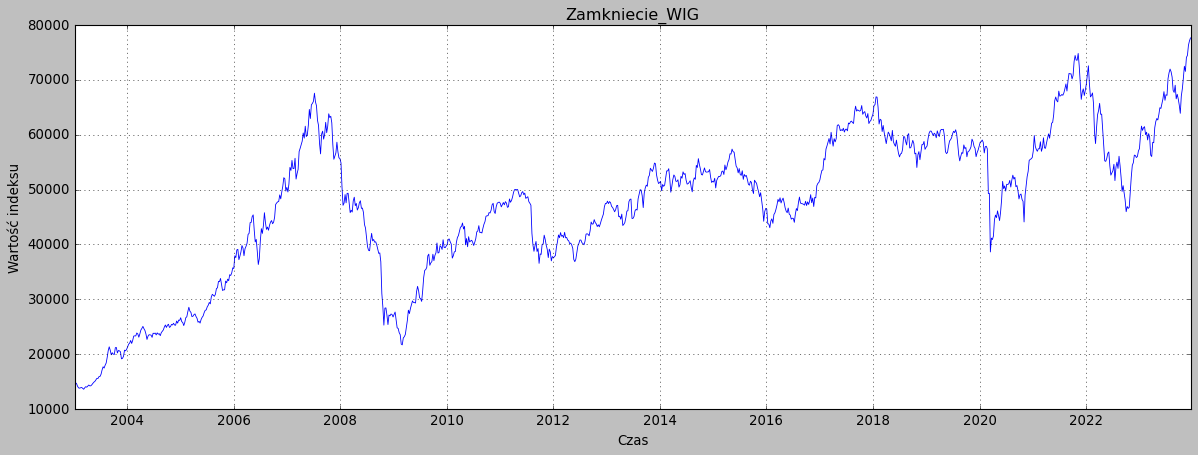

In [109]:
# wartość indeksu WIG w badanym okrecie
walor = zamkniecia_df.columns[-1] 

# dane
plt.plot(zamkniecia_df[walor]) 

plt.title(f'{walor}')
plt.xlabel('Czas')
plt.ylabel('Wartość indeksu')
plt.grid(True, linestyle='dotted')

plt.show()

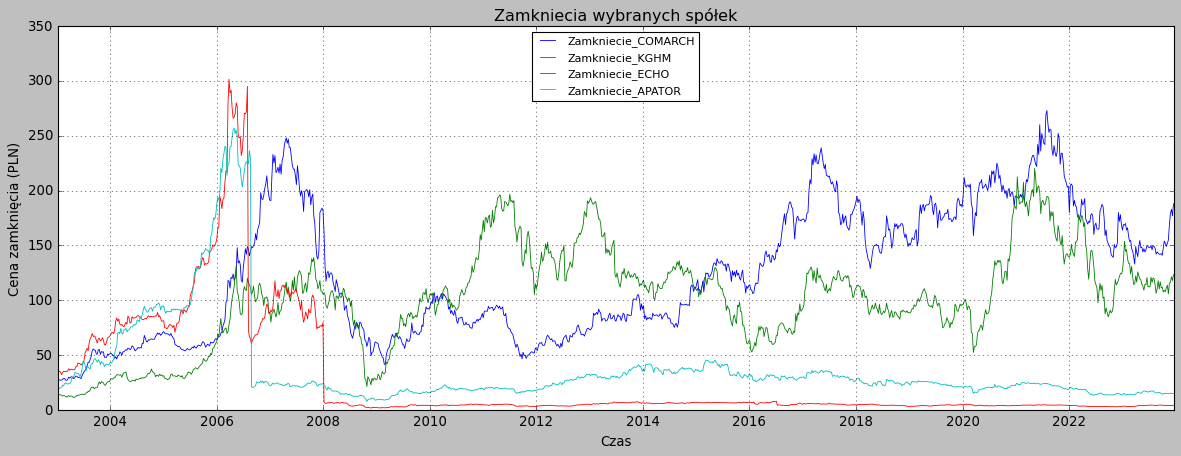

In [110]:
# wartość danego waloru w badanym okrecie
for walor in range(len(spolki_df.columns)):
    plt.plot(zamkniecia_df[spolki_df.columns[walor]], label=spolki_df.columns[walor]) 

plt.title(f'Zamkniecia wybranych spółek')
plt.xlabel('Czas')
plt.ylabel('Cena zamknięcia (PLN)')
plt.grid(True,linestyle='dotted') 
plt.legend(fontsize='10', loc='upper center')

plt.show()

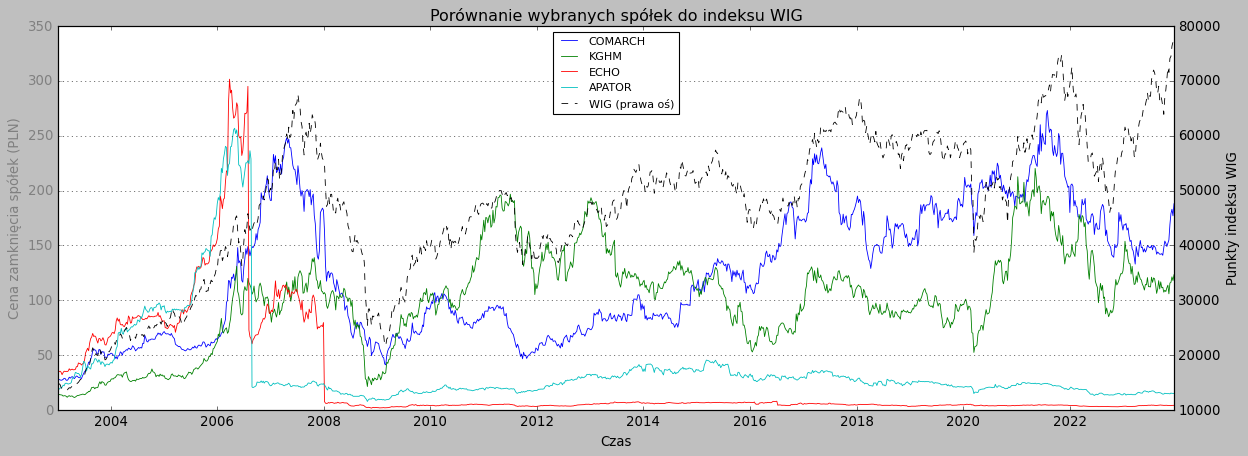

In [111]:
# porównanie wybranych spółek do indeksu WIG

# parametry pierwszego wykresu (lewa oś y)
fig, ax1 = plt.subplots()

# wizualizacja wybranych spółek w badanym okrecie (lewa oś y)
for walor in range(len(spolki_df.columns)):
    ax1.plot(zamkniecia_df[spolki_df.columns[walor]], linestyle='-', label=spolki_df.columns[walor][11:]) 
ax1.set_xlabel('Czas')
ax1.set_ylabel('Cena zamknięcia spółek (PLN)', color='grey')
ax1.tick_params('y', colors='grey')

# parametry drugiego wykresu (prawa oś y; ta sama oś x)
ax2 = ax1.twinx()

# wizualizacja ineksu WIG w badanym okrecie (prawa oś y)
wig = zamkniecia_df.columns[-1]
ax2.plot(zamkniecia_df[wig], color='black', linestyle='--', label=f'{wig[11:]} (prawa oś)')
ax2.set_ylabel('Punkty indeksu WIG', color='black')
ax2.tick_params('y', colors='black')

# kreślenie wykresów
plt.title(f'Porównanie wybranych spółek do indeksu WIG')
lines, labels = ax1.get_legend_handles_labels()
lines_wig, labels_wig = ax2.get_legend_handles_labels()
ax2.legend(lines + lines_wig, labels + labels_wig, fontsize='10', loc='upper center')
plt.grid(True, linestyle='dotted') 
plt.show()

### Graficzna prezentacja zamienności tygodniowych zamknięć wskaźników

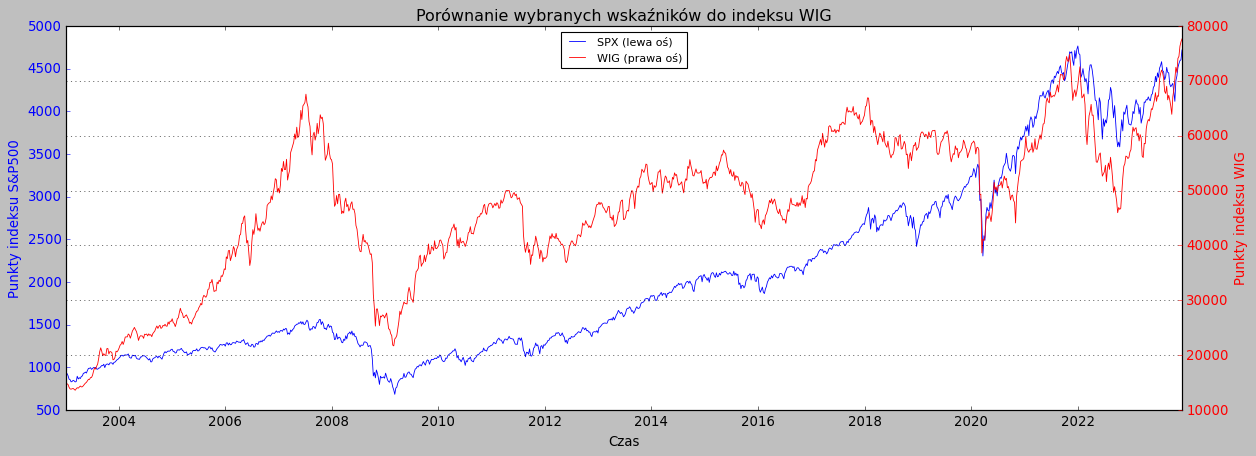

In [112]:
# Porównanie zmienności indeksu SP500 i inteksu WIG w badanym okresie

# parametry pierwszego wykresu (lewa oś y)
fig, ax1 = plt.subplots()

# wizualizacja danych na lewej osi y
sp500 = zamkniecia_df.columns[3]
ax1.plot(zamkniecia_df[sp500], color='b', linestyle='-', label=f'{sp500[11:]} (lewa oś)')

ax1.set_xlabel('Czas')
ax1.set_ylabel('Punkty indeksu S&P500', color='b')
ax1.tick_params('y', colors='b')

# parametry wykresu dl prawej osi y (ta sama oś x)
ax2 = ax1.twinx()

# wizualizacja ineksu WIG w badanym okrecie (prawa oś y)
wig = zamkniecia_df.columns[-1]
ax2.plot(zamkniecia_df[wig], color='r', linestyle='-', label=f'{wig[11:]} (prawa oś)')
ax2.set_ylabel('Punkty indeksu WIG', color='r')
ax2.tick_params('y', colors='r')

# kreślenie wykresów
plt.title(f'Porównanie wybranych wskaźników do indeksu WIG')
lines, labels = ax1.get_legend_handles_labels()
lines_wig, labels_wig = ax2.get_legend_handles_labels()
ax2.legend(lines + lines_wig, labels + labels_wig, fontsize='10', loc='upper center')
plt.grid(True, linestyle='dotted') 
plt.show()

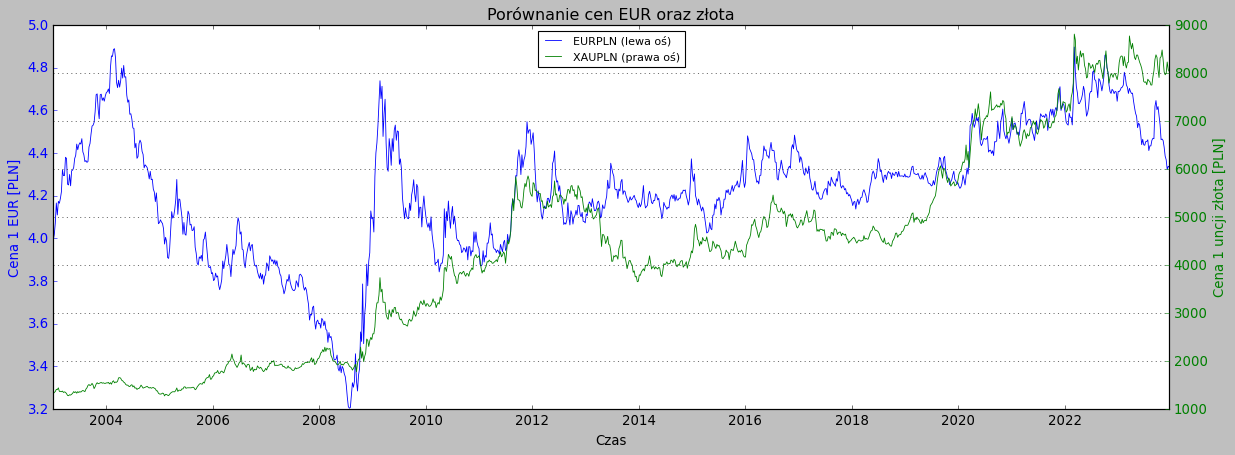

In [113]:
# Porównanie zmienności cen EUR oraz cen złota w badanym okresie

# parametry pierwszego wykresu (lewa oś y)
fig, ax1 = plt.subplots()

# wizualizacja danych na lewej osi y
eur = zamkniecia_df.columns[2]
ax1.plot(zamkniecia_df[eur], color='b', linestyle='-', label=f'{eur[11:]} (lewa oś)')

ax1.set_xlabel('Czas')
ax1.set_ylabel('Cena 1 EUR [PLN]', color='b')
ax1.tick_params('y', colors='b')

# parametry wykresu dl prawej osi y (ta sama oś x)
ax2 = ax1.twinx()

# wizualizacja ineksu WIG w badanym okrecie (prawa oś y)
zloto = zamkniecia_df.columns[5]
ax2.plot(zamkniecia_df[zloto], color='g', linestyle='-', label=f'{zloto[11:]} (prawa oś)')
ax2.set_ylabel('Cena 1 uncji złota [PLN]', color='g')
ax2.tick_params('y', colors='g')

# kreślenie wykresów
plt.title(f'Porównanie cen EUR oraz złota')
lines, labels = ax1.get_legend_handles_labels()
lines_wig, labels_wig = ax2.get_legend_handles_labels()
ax2.legend(lines + lines_wig, labels + labels_wig, fontsize='10', loc='upper center')
plt.grid(True, linestyle='dotted') 
plt.show()

___
## Statystyka opisowa
### Dla spółki Comarch (jako przykład)

In [80]:
comarch_cols = ["Zamkniecie_COMARCH", "Wolumen_COMARCH"]

### Wybrane miary zmienności
- Rozstęp
- Odchylenie ćwiartkowe
- Wariancja
- Odchylenie standardowe
- Współczynnik zmienności

### Wybrane miary pozycyjne
- Średnia
- Kwantyle
- Mediana (kwantyl 50%)
- Moda

### Wybrane miary kształtu
- Skośność
- Kurtoza

In [81]:
# Przygotowanie parametrów statystycznych

# własna funkcja do obliczania inter quartile range (IQR)
def q25(column):
    return column.quantile(0.25)
def q75(column):
    return column.quantile(0.75)    
def IQR(column): 
    q25, q75 = column.quantile([0.25, 0.75])
    return q75-q25

# własna funkcja do obliczania zakresu
def range_max_min(column):
    return column.max() - column.min()

# własna funkcja do obliczania współczynnika zmienności (coefficient of variance)
def cv(column):
    return stats.variation(list(column)) * 100

# własna funkcja do wyznaczania błędu standardowego
def sem(column):
    return stats.sem(list(column))

# własna funkcja do wyznaczenia przedziału ufności dla średniej
def ci(column):
    conf_level = 0.95
    dof = len(column) - 1
    sem = stats.sem(list(column))
    # return stats.t.interval(conf_level, dof, np.mean(column), sem)

    lower, upper = stats.t.interval(conf_level, dof, np.mean(column), sem)
    lower = round(lower, 3)
    upper = round(upper, 3)
    return lower, upper

charakterystyka = ["min", q25, "mean", "median", q75, IQR, "max", range_max_min, "var", "std", cv, sem, ci, "skew", "kurtosis"]

In [82]:
merged_df[comarch_cols].agg(charakterystyka)

,Zamkniecie_COMARCH,Wolumen_COMARCH
min,26.998967,414.209002
q25,69.999972,8167.88004
mean,124.790129,31502.620402
median,117.210668,16970.808795
q75,175.999543,36870.601798
IQR,105.999572,28702.721758
max,272.999654,431401.754479
range_max_min,246.000687,430987.545477
var,3496.816984,1853908016.174635
std,59.13389,43057.032134


### Interpretacja wybranych statystyk dla _cen zamknięcia_ akcji Comarch w interwałach tygodniowych

$min$ -> najniższa cena akcji Comarch na zamknięciu tygodniowym w obserwowanym okresie

$max$ -> najwyższa cena akcji na zamknięciu tygodniowym 

$mean$ -> średnia arytmetyczna cen zamknięcia

$median$ -> mediana (wartość środkowa); wartość mniejsza od średniej wskazuje na skośność statystyki

$std$ -> odchylenie standardowe wyrażone w PLN; stosunkowo duża wartość $std$ w stosunku do średniej wskazuje na znaczny rozrzut zmiennej 

$cv$ -> współczynnik zmienności; średnia / odchylenie standardowe

$sem$ -> błąd standardowy średniej; rozrzut estymatorów z próby wokół parametru populacji, czyli jak bardzo średnia próbki jest "rozmyta" (miara niepewności testu)

$ci$ -> przedział ufności; z prawdopodobieństwem 0.95 prawdziwa wartość parametru populacyjnego (średnia cen zamknięcia) znajduje się w tym przedziale

$skew$ -> skośność; wartość większa od 1 świadczy o skośności lewostronnej

$kurtosis$ -> kurtoza; bada czy rozkład jest płaski, czy stromy; kurtoza < 0 wskazuje na rozkład platykurtyczny, czyli rozkład niski i szeroki (Wartości zmiennej są bardziej rozrzucone wokół średniej oraz mamy mniejsze prawdopodobieństwo wystąpienia wartości ekstremalnych)


___
## Analiza kursu EUR - PLN
### Najważniejsze parametry statystyczne

In [83]:
parametry_eurpln = merged_df["Zamkniecie_EURPLN"].agg(charakterystyka)

In [84]:
min_eurpln = parametry_eurpln.iloc[0]
mean_eurpln = parametry_eurpln.iloc[2]
max_eurpln = parametry_eurpln.iloc[6]
std_eurpln = parametry_eurpln.iloc[9]
skew_eurpln = parametry_eurpln.iloc[13]
kurt_eurpln = parametry_eurpln.iloc[14]

### Histogram

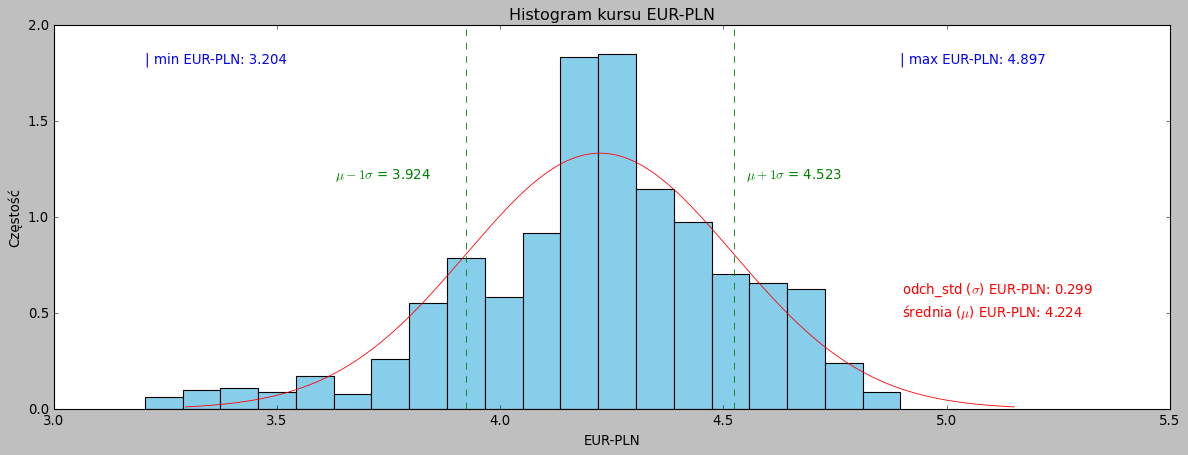

In [114]:
# Utwórzenie histogram
plt.hist(merged_df["Zamkniecie_EURPLN"], bins=20, density=True, color='skyblue')

# Wykreślenie krzywej gęstości prawdopodobieństwa (pdf)
# xmin, xmax = plt.xlim()
# x_zakres = np.linspace(xmin, xmax, 1000)
x_zakres = np.linspace(mean_eurpln - 3.1 * std_eurpln, mean_eurpln + 3.1 * std_eurpln, 1000)
plt.plot(x_zakres, stats.norm.pdf(x_zakres, mean_eurpln, std_eurpln), 'r')

# oznaczenie zakresu -odch-std oraz +odch_std
plt.axvline(mean_eurpln-std_eurpln, color='g', linestyle='--')
plt.axvline(mean_eurpln+std_eurpln, color='g', linestyle='--')

# Opis wykresu i osi
plt.title('Histogram kursu EUR-PLN')
plt.xlabel('EUR-PLN')
plt.ylabel('Częstość')
plt.text(min_eurpln, 1.8, f'| min EUR-PLN: {min_eurpln:.3f}', color='b')
plt.text(max_eurpln, 1.8, f'| max EUR-PLN: {max_eurpln:.3f}', color='b')
plt.text(4.9, 0.48, f'średnia ($\mu$) EUR-PLN: {mean_eurpln:.3f}', color='r')
plt.text(4.9, 0.60, f'odch_std ($\sigma$) EUR-PLN: {std_eurpln:.3f}', color='r')
plt.text(3.63, 1.2, f'$\mu-1 \sigma$ = {mean_eurpln-std_eurpln:.3f}', color='g')
plt.text(4.55, 1.2, f'$\mu+1 \sigma$ = {mean_eurpln+std_eurpln:.3f}', color='g')

# Kreślenie
plt.show()

Rozkład z grubsza przypomina normalny, choć nie-symetryczny i ściśnięty blisko wartości oczekiwanej. Porównajmy zatem niektóre parametry rozkładu.

In [115]:
print(f'skew \t   {stats.skew(merged_df["Zamkniecie_EURPLN"]):.6f}')
print(f'kurtosis    {stats.kurtosis(merged_df["Zamkniecie_EURPLN"]):.6f}')

skew 	   -0.547283
kurtosis    0.620155


Zatem wnioskujemy, iż:  
a) rozkład jest jednak względnie symetryczny, ponieważ skośność w zakresie <-1,1>  
b) leptokurtyczny (tj. ściśnięty), ponieważ kurtoza > 0

### Wyznaczenie trzech sigm dla cen zamknięcia EUR-PLN

In [116]:
# Wartości Z-score dla trzech odchyleń standardowych
zakres_sigm = [-3, -2, -1, 1, 2, 3]

print(f'Wartość oczekiwana (średnia): {mean_eurpln:.4f}')
print(f'Odchylenie standardowe: {std_eurpln:.4f}')

# Oblicz dystrybuantę dla odchyleń standardowych (wartość Z-score)
sigmy = [s * std_eurpln + mean_eurpln for s in zakres_sigm]
for s in sigmy:
    cumulative_probability = stats.norm.cdf(s, loc=mean_eurpln, scale=std_eurpln)
    print(f'Dystrybuanta dla {(s-mean_eurpln)/std_eurpln:.0f} sigma ({s:.4f} PLN): {cumulative_probability:.4f}')

Wartość oczekiwana (średnia): 4.2236
Odchylenie standardowe: 0.2994
Dystrybuanta dla -3 sigma (3.3254 PLN): 0.0013
Dystrybuanta dla -2 sigma (3.6248 PLN): 0.0228
Dystrybuanta dla -1 sigma (3.9242 PLN): 0.1587
Dystrybuanta dla 1 sigma (4.5230 PLN): 0.8413
Dystrybuanta dla 2 sigma (4.8224 PLN): 0.9772
Dystrybuanta dla 3 sigma (5.1218 PLN): 0.9987


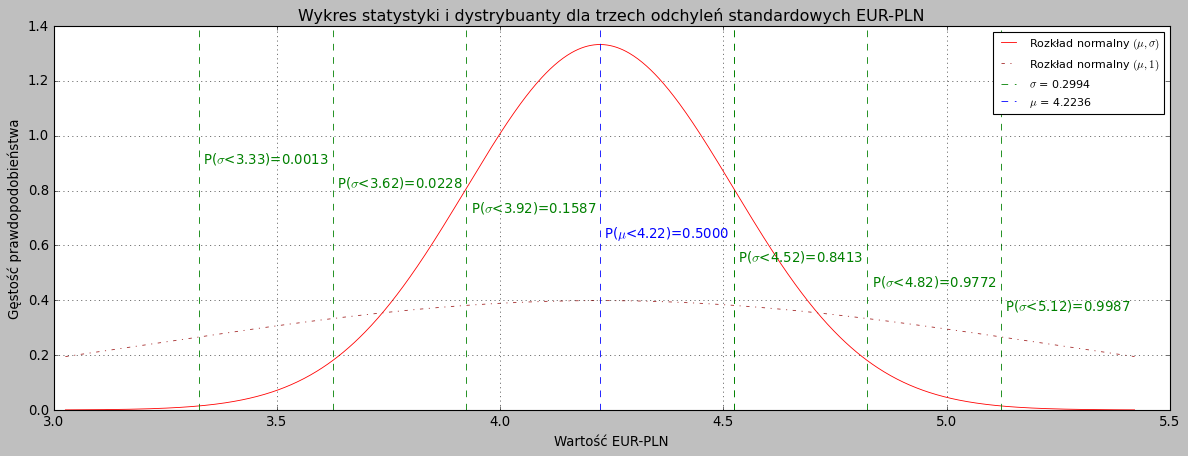

In [125]:
# Analiza graficzna trzech sigm

# Tworzenie danych dla osi X (wartości Z-score)
x_zakres = np.linspace(mean_eurpln - 4 * std_eurpln, mean_eurpln + 4 * std_eurpln, 1000)

# Tworzenie wykresu statystyki
plt.plot(x_zakres, stats.norm.pdf(x_zakres, mean_eurpln, std_eurpln), 'r', label=f'Rozkład normalny $(\mu, \sigma)$')
plt.plot(x_zakres, stats.norm.pdf(x_zakres, loc=mean_eurpln, scale=1), color='brown', linestyle='-.', label=f'Rozkład normalny $(\mu, 1)$')
plt.axvline(mean_eurpln + std_eurpln, color='g', linestyle='--', label=f'$\sigma$ = {std_eurpln:.4f}')

# wartość oczekiwana
plt.axvline(mean_eurpln, color='b', linestyle='--', label=f'$\mu$ = {mean_eurpln:.4f}')

# Dodanie dystrybuant dla różnych odchyleń standardowych
for s in sigmy:
    plt.axvline(s, color='g', linestyle='--')#, label=f'{(s-mean_eurpln)/std_eurpln:.0f}$\sigma$ = {s:.4f}')

    # Obliczanie dystrybuanty dla danej sigmy
    cumulative_probability = stats.norm.cdf(s, loc=mean_eurpln, scale=std_eurpln)
    plt.text(.01+s, 1.9+s*-.3, f'P($\sigma$<{s:.2f})={cumulative_probability:.4f}', color='g')

plt.text(mean_eurpln+.01, 0.63, f'P($\mu$<{mean_eurpln:.2f})={stats.norm.cdf(mean_eurpln, loc=mean_eurpln, scale=std_eurpln):.4f}', color='b')

# Konfiguracja wykresu
plt.title('Wykres statystyki i dystrybuanty dla trzech odchyleń standardowych EUR-PLN')
plt.xlabel('Wartość EUR-PLN')
plt.ylabel('Gęstość prawdopodobieństwa')
plt.legend(fontsize='10')
plt.grid(True)
plt.show()

___
## Testy statystyczne
### Czy częstość występowania cen EUR-PLN ma rozkład normalny

In [89]:
# Test Kołmogorowa-Smirnowa
# ref: https://www.statology.org/kolmogorov-smirnov-test-python/
statistic, p_value = stats.kstest(merged_df['Zamkniecie_EURPLN'], 'norm')
print("Statystyka testowa:", statistic)
print("Wartość p:", p_value)

# Interpretacja wyników
alpha = 0.05
if p_value > alpha:
    print("Wniosek: nie ma podstaw do odrzucenia hipotezy zerowej (o normalności rozkładu).")
else:
    print("Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).")

Statystyka testowa: 0.9993218667162591
Wartość p: 0.0
Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).


In [90]:
# Test D'Agostino i Pearson:
statistic, p_value = stats.normaltest(merged_df['Zamkniecie_EURPLN'])

print("Statystyka testowa:", statistic)
print("Wartość p:", p_value)

# Interpretacja wyników
alpha = 0.05
if p_value > alpha:
    print("Wniosek: nie ma podstaw do odrzucenia hipotezy zerowej (rozklad normalny).")
else:
    print("Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).")

Statystyka testowa: 60.17132120784457
Wartość p: 8.589415573446294e-14
Wniosek: odrzucono hipotezę zerową na korzyść hipotezy alternatywnej (nie normalny rozklad).


___
## Analiza portfelowa
Na przykładzie cen zamknięcia spółki Comarch wobec indeksu WIG

### Wyznaczenie korelacji

In [91]:
# Dane (zmienne niezależne i zależna)
x = merged_df['Zamkniecie_WIG']
y = merged_df['Zamkniecie_COMARCH']

# Obliczenie współczynnika korelacji (Pearson)
correlation_coefficient = np.corrcoef(x, y)[0, 1]
# Wyświetlenie współczynnika korelacji
print(f'Współczynnik korelacji: {correlation_coefficient:.3f}')

Współczynnik korelacji: 0.804


### Model regresji liniowej

Współczynnik nachylenia (a): [0.73127588]
Wyraz wolny (b): [0.00144535]
Współczynnik determinacji (R^2): 0.1844239019603393


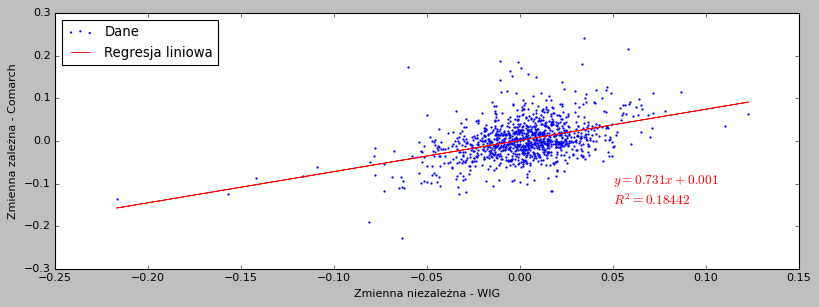

In [92]:
# Przekształcenie elementów serii, tak aby uzyskać procentową zmianę między elementami, tj. stopę zwrotu (bieżący/poprzedni - 1) 
x = merged_df['Zamkniecie_WIG'].pct_change().dropna()
y = merged_df['Zamkniecie_COMARCH'].pct_change().dropna()  

# Przekształcenie danych do postaci wymaganej przez scikit-learn
# ref: https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape
X = x.values.reshape(-1, 1)
y = y.values.reshape(-1, 1)

# Inicjalizacja modelu regresji liniowej
model = LinearRegression()

# Dopasowanie modelu do danych
model.fit(X, y)

# Wyświetlenie wyników regresji
print("Współczynnik nachylenia (a):", model.coef_[0])
print("Wyraz wolny (b):", model.intercept_)
print("Współczynnik determinacji (R^2):", model.score(X, y))

# Dodanie równania regresji liniowej na wykresie
equation = f'$y = {float(model.coef_[0]):.3f}x + {float(model.intercept_):.3f}$'
plt.annotate(equation, xy=(0.05, -.1), fontsize=12, color='red')
r = f'$R^2 = {model.score(X, y):.5f}$'
plt.annotate(r, xy=(0.05, -.15), fontsize=12, color='red')

# Wykres danych i regresji
plt.scatter(x, y, color='blue', label='Dane', s=1)
plt.plot(x.values.reshape(-1, 1), model.predict(X), color='red', label='Regresja liniowa')
plt.xlabel('Zmienna niezależna - WIG')
plt.ylabel('Zmienna zależna - Comarch')
plt.legend(loc='upper left')
plt.show()

Interpretacja:
- Ponieważ współczynnik kierunkowy jest różny od zera (w stopniu 'na oko' wystarczająco istotnym - do sprawdzenia), oraz dodatni, istnieje dodatnia korelacja między cenami spółki Comarch i wartościami indeksu WIG.
- Wyraz wolny jest bardzo bliski zeru (do sprawdzenia czy istotnie bliski), zatem zachowanie cen spółki Comarch sugeruje bliskie odwzorowanie zachowania indeksu WIG (ani systematycznie nie bije rynku, ani systematycznie nie przegrywa z rynkiem).

___
### Model wielowymiarowy regresji liniowej  

Model wielowymiarowej regresji liniowej uwzględnia więcej niż jedną zmienną niezależną (cechę).  

W przypadku regresji liniowej wielowymiarowej mamy więcej niż jedną zmienną niezależną (predyktor).
Model ten pozwala na uwzględnienie wpływu wielu zmiennych niezależnych na zmienną zależną.

Regresja liniowa wielowymiarowa pozwala uwzględnić więcej niż jedną zmienną niezależną, umożliwiając uwzględnienie wpływu wielu zmiennych na zmienną zależną.
Przykładowe równanie regresji liniowej wielowymiarowej dla dwóch zmiennych:
     $$Y = a_1X_1 + a_2X_2 + ... + a_nX_n + \varepsilon$$

W poniższej analizie zmienną zależną (objaśnianą) będzie cena zamknięcia spółki **Comarch**, oraz przyjmiemy następujące zmienne niezależne (objaśniające):
- zamknięcia spółki KGHM
- zamknięcia spółki Echo
- zamknięcia spółki Apator
- indeks WIG
- indeks S&P500
- kurs EUR-PLN
- kurs złota

W modelu wielowymiarowej regresji zastosujemy metodę krokową wsteczną. W praktyce podejmiemy następujące iteracyjne działania:
1. budujemy model dla wszystkich powyżej wymienionych zmienne niezależne $X_1, X_2, ..., X_n$
2. sukcesywnie pojedynczo w kolejnych krokach eliminujemy tą zmienną niezależną, która jest najgorzej powiązana z Y (mierzone za pomocą _testu t-studenta_, tj. testujemy $H0$ (współczynnik $a_i$ nieistotny) lub $H1$ (współczynnik 
$a_i$ istotny)); zależy nam, żeby pozostały zmienne z jak największą siłą, czyli największym $p-value$; innymi słowy odrzucamy $H1$ lub $H0$ o najmniejszym $p-value$
3. powtarzamy punkt 2., aż zostaną w modelu zmienne o $p-value < \alpha = 0.05%$

In [93]:
# Przygotowania danych

# Przypisanie zmiennych niezależnych i zależnej
niezalezne = ['Zamkniecie_KGHM', 'Zamkniecie_ECHO', 'Zamkniecie_APATOR', 'Zamkniecie_WIG', 'Zamkniecie_SPX', 'Zamkniecie_EURPLN', 'Zamkniecie_XAUPLN']
X_wielo = merged_df[niezalezne]
y_wielo = merged_df['Zamkniecie_COMARCH']

# Przekształcenie elementów serii, tak aby uzyskać procentową stopę zwrotu (bieżący/poprzedni - 1) 
X_wielo = X_wielo.pct_change().dropna()
y_wielo = y_wielo.pct_change().dropna()

In [94]:
# podgląd zmiennych niezależnych
X_wielo

,Zamkniecie_KGHM,Zamkniecie_ECHO,Zamkniecie_APATOR,Zamkniecie_WIG,Zamkniecie_SPX,Zamkniecie_EURPLN,Zamkniecie_XAUPLN
Data,,,,,,,
2003-01-12,0.014575,-0.025662,0.039518,0.001043,0.020890,0.006841,0.019712
2003-01-19,-0.010586,0.014910,0.056661,-0.010037,-0.027804,0.013266,0.014126
2003-01-26,-0.006754,-0.025958,0.012026,-0.034412,-0.044778,0.023262,0.033724
2003-02-02,-0.018484,-0.066119,0.029700,-0.020447,-0.006617,-0.013491,-0.004255
2003-02-09,-0.066655,0.059601,0.091951,-0.003431,-0.030396,0.015549,0.025641
...,...,...,...,...,...,...,...
2023-11-19,0.093012,-0.012285,-0.016725,0.035586,0.022373,-0.009545,-0.007377
2023-11-26,0.004752,-0.004975,0.051020,0.005104,0.010040,-0.003890,0.003639
2023-12-03,0.043852,0.050000,-0.019417,0.024830,0.007740,-0.010316,0.029660


In [95]:
# Przygotowanie funkcji, z wykorzystaniem modelu Ordinary Least Squares(OLS) z pakietu Statsmodel
def wsteczna_eliminacja(X_wielo, y_wielo):
    
    num_vars = len(X_wielo.columns) # liczba zmiennych zależnych
    print(f'Początkowa liczba zmiennych niezależnych: {num_vars}')
    
    alpha = 0.05    
    for i in range(0, num_vars):
        print(f'Iteracja: {i+1}. p-value zmiennych niezależnych:')
        regressor_OLS = sm.OLS(y_wielo, X_wielo).fit() # najpierw y i następnie X
        max_var = max(regressor_OLS.pvalues) # wyznaczamy zmienną niezależną o największym p-value
        print(regressor_OLS.pvalues.to_string())
        if max_var > alpha: # alfa (poziom istotności)
            for j in range(0, num_vars - i):
                if regressor_OLS.pvalues.iloc[j] == max_var:
                    print(f'Największe p-value: {max_var:.5} dla zmiennej "{X_wielo.columns[j]}", którą usunięto.\n')
                    X_wielo = X_wielo.drop(X_wielo.columns[j], axis=1) # usunięcie zmiennej najgorzej powiązanej z Y
        else:
            print(f'p-value żadnej zmiennej niezależnej nie jest większa od przyjętego alfa (alfa={alpha}), zatem żadna nie jest usunięta. Dalsza iteracja przerwana.\n')
            break
            
    print(regressor_OLS.summary())
    return X_wielo

In [96]:
# Wywołanie funkcji eliminacji zmiennych
X_optimal = wsteczna_eliminacja(X_wielo, y_wielo)

Początkowa liczba zmiennych niezależnych: 7
Iteracja: 1. p-value zmiennych niezależnych:
Zamkniecie_KGHM      4.890026e-01
Zamkniecie_ECHO      1.930336e-03
Zamkniecie_APATOR    2.669482e-02
Zamkniecie_WIG       4.390717e-16
Zamkniecie_SPX       1.328779e-01
Zamkniecie_EURPLN    5.667041e-01
Zamkniecie_XAUPLN    4.366117e-01
Największe p-value: 0.5667 dla zmiennej "Zamkniecie_EURPLN", którą usunięto.

Iteracja: 2. p-value zmiennych niezależnych:
Zamkniecie_KGHM      4.628270e-01
Zamkniecie_ECHO      1.514578e-03
Zamkniecie_APATOR    2.830859e-02
Zamkniecie_WIG       2.926455e-16
Zamkniecie_SPX       1.524314e-01
Zamkniecie_XAUPLN    5.589789e-01
Największe p-value: 0.55898 dla zmiennej "Zamkniecie_XAUPLN", którą usunięto.

Iteracja: 3. p-value zmiennych niezależnych:
Zamkniecie_KGHM      4.193571e-01
Zamkniecie_ECHO      1.434735e-03
Zamkniecie_APATOR    2.775027e-02
Zamkniecie_WIG       1.360143e-16
Zamkniecie_SPX       1.133923e-01
Największe p-value: 0.41936 dla zmiennej "Zamkniecie

### Interpretacja

- $R^2$ to miara, która informuje o stopniu dopasowania modelu do danych. Wartość 0.199 oznacza, że około 19.9% zmienności zależnej zmiennej (`Zamkniecie_COMARCH`) jest wyjaśniane przez model. 
- Statystyka F jest używana do oceny ogólnego dopasowania modelu. Wartość 90.13 oznacza, że model jest statystycznie znaczący.
- Współczynniki kierunkowe (coef) reprezentują wpływ danej zmiennej niezależnej na zmienną zależną. Na przykład, dla zmiennej `Zamkniecie_ECHO`, współczynnik wynosi 0.0747.
- Błąd standardowy dla współczynnika. Im niższa wartość, tym bardziej pewne są estymowane współczynniki.
- Wartość t-stat mierzy, jak bardzo estymowany współczynnik różni się od zera. Im większa wartość t-statistic, tym bardziej istotna statystycznie jest zmienna.
- Przedział ufności (<0.025, 0.975>) oznacza to, że z prawdopodobieństwem 0.95 współczynnik leży w tym przedziale.
- p-value informuje o istotności statystycznej każdej zmiennej niezależnej. Jeśli $p-value < \alpha$, to zmienna jest uważana za istotną statystycznie. Za istotne, a więc mające wpływ na zmienną zależną `Zamkniecie_COMARCH`, uznajemy zatem następujące zmienne niezależne: `Zamkniecie_ECHO`, `Zamkniecie_APATOR` oraz `Zamkniecie_WIG`.
- $p-value$ pozostałych zmiennych niezależnych (tj. których $p-value > \alpha$, zostały usunięte, jako statystycznie nie istotne.

___
## Dodatkowe źródła
- [https://mateuszgrzyb.pl/3-metody-analizy-normalnosci-rozkladu-w-python/](https://mateuszgrzyb.pl/3-metody-analizy-normalnosci-rozkladu-w-python/)
- [https://github.com/bilalonur/financial-visualization/blob/main/finance-visualization.ipynb](https://github.com/bilalonur/financial-visualization/blob/main/finance-visualization.ipynb)
- [https://python.cogsci.nl/numerical/statistics/](https://python.cogsci.nl/numerical/statistics/)
- [https://pingouin-stats.org/](https://pingouin-stats.org/)
- [https://www.naukowiec.org/wiedza/statystyka/](https://www.naukowiec.org/wiedza/statystyka/)
- [https://www.geeksforgeeks.org/interpreting-the-results-of-linear-regression-using-ols-summary/](https://www.geeksforgeeks.org/interpreting-the-results-of-linear-regression-using-ols-summary/)
- [https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a](https://medium.com/swlh/interpreting-linear-regression-through-statsmodels-summary-4796d359035a)
- [https://www.statology.org/kolmogorov-smirnov-test-python/](https://www.statology.org/kolmogorov-smirnov-test-python/)
- [https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape](https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape)

___
Andrzej Kocielski, 2024